# Data Project

> **Note:** 
> 1. This is a starting point for how to structure your data project 
> 1. The `dataproject.py` file includes functions which can be in this notebook

Import and set magics:

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject

# data analysis modules
import pandas as pd
import matplotlib.pyplot as plt
from dstapi import DstApi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

### 1.1 Basics:

We load the data from ....

In [117]:
# load CPI data from DST
dst = DstApi('PRIS113')
df = dst.get_data()

C:\Users\tobia\AppData\Local\Temp\ipykernel_7952\2163139989.py:3: UserWarning: API call parameters are not specified. Parameters resulting in the download of the entire table will be automatically generated. This can result in massive data downloads.
  df = dst.get_data()


In [118]:
#sort by time (TID)
df = df.sort_values('TID')

#reset index after sorting
df = df.reset_index(drop=True)

#rename indhold to CPI
df = df.rename(columns={'INDHOLD': 'CPI'})

#Format the TID column to datetime
df['time'] = pd.to_datetime(df['TID'], format='%YM%m')

#Index the consumerpriceindex(CPI) to 100 on average in 2020
df['CPI'] = df['CPI'] / df[df['time'].dt.year == 2020]['CPI'].mean() * 100
df.head()




,TYPE,TID,CPI,time
0,Forbrugerprisindeks,1980M01,31.904608,1980-01-01
1,Forbrugerprisindeks,1980M02,32.194650,1980-02-01
2,Forbrugerprisindeks,1980M03,32.678053,1980-03-01
3,Forbrugerprisindeks,1980M04,32.871415,1980-04-01
4,Forbrugerprisindeks,1980M05,33.354818,1980-05-01


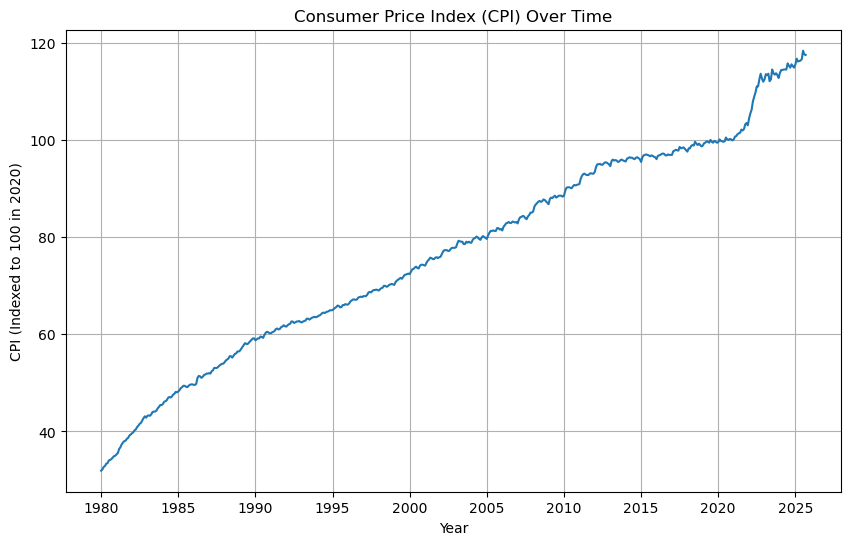

In [119]:
# plot CPI over time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['CPI'])
plt.title('Consumer Price Index (CPI) Over Time')
plt.xlabel('Year')
plt.ylabel('CPI (Indexed to 100 in 2020)')
plt.grid()
plt.show()

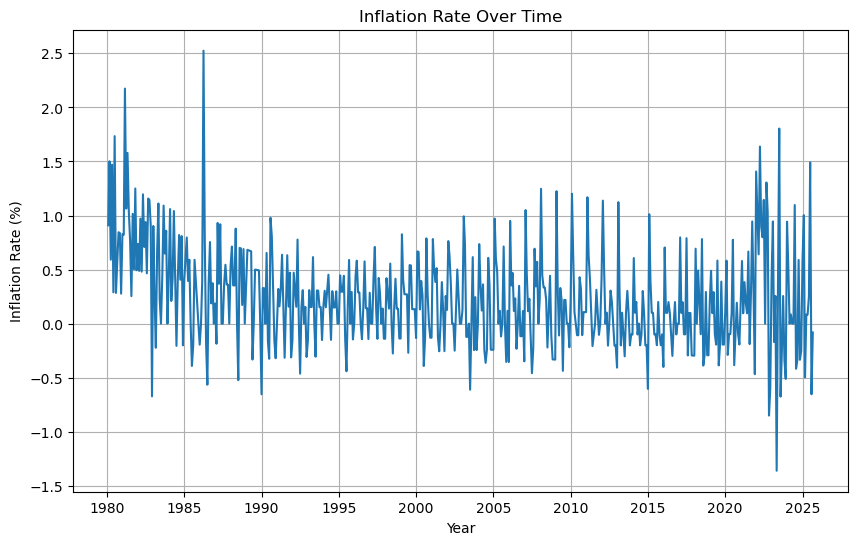

In [120]:
# Calculate the month to month inflation rate
df['inflation_rate'] = df['CPI'].pct_change() * 100
df.head()

# Plot the inflation rate over time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['inflation_rate'])
plt.title('Inflation Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid()
plt.show()

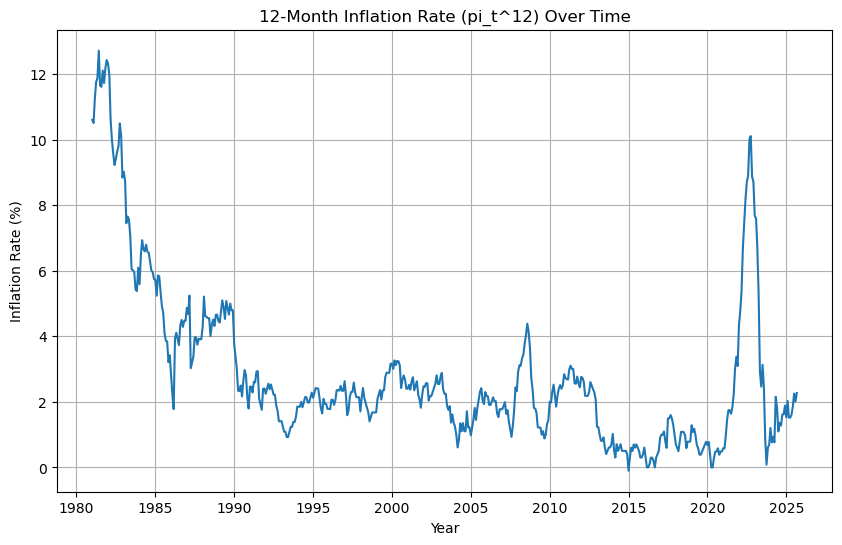

In [121]:
# Calculate the 12-month inflation rate (pi_t^12=p_t/p_(t-12)-1)
df['pi_t^12'] = df['CPI'] / df['CPI'].shift(12) - 1
df.head()
# Plot the 12-month inflation rate over time
plt.figure(figsize=(10,6))
plt.plot(df['time'], df['pi_t^12'] * 100)
plt.title('12-Month Inflation Rate (pi_t^12) Over Time')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.grid()
plt.show()

The figure shows that Danish inflation increased sharply during **2021–2022**.  
Inflation **peaked around autumn 2022** at approximately **10%**, after which it started to decline rapidly.  
By **spring 2023**, inflation had fallen back to around **2–3%** and remained relatively stable thereafter.  
This suggests that **the post-pandemic inflation surge ended around March–May 2023**, when price growth returned to a more normal level.

### 1.2 Instantaneous inflation

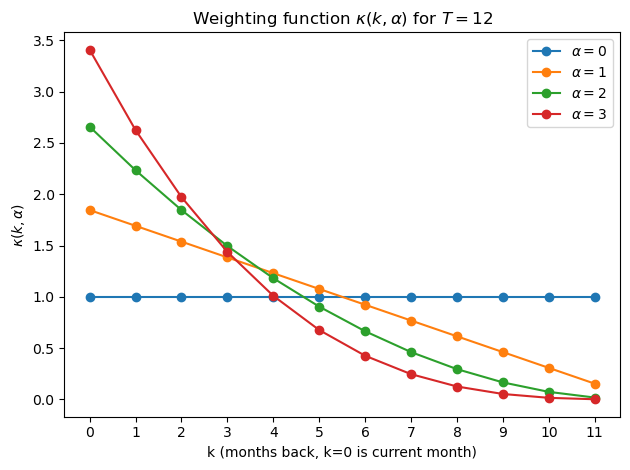

In [122]:
# Weighting function kappa(k, alpha) for T=12
T = 12
k = np.arange(0, T)  # k = 0..11

def kappa(k_vals, alpha, T=12):
    w = (T - k_vals) ** alpha
    w = w / w.sum() * T           # scale so weights sum to T
    return w

plt.figure()
for a in [0, 1, 2, 3]:
    plt.plot(k, kappa(k, a), marker='o', label=fr'$\alpha={a}$')

plt.xticks(k)
plt.xlabel('k (months back, k=0 is current month)')
plt.ylabel(r'$\kappa(k,\alpha)$')
plt.title(r'Weighting function $\kappa(k,\alpha)$ for $T=12$')
plt.legend()
plt.tight_layout()
plt.show()

In [123]:
# Compute the weighted 12-month inflation rate for alpha = 0,1,2,3
for alpha in [0,1,2,3]:
    weights = kappa(np.arange(12), alpha)  # length 12
    df[f'pi12_alpha{alpha}'] = (df['pi_t^12'].rolling(12).apply(lambda x: np.prod((1+x)**weights) - 1, raw=True))



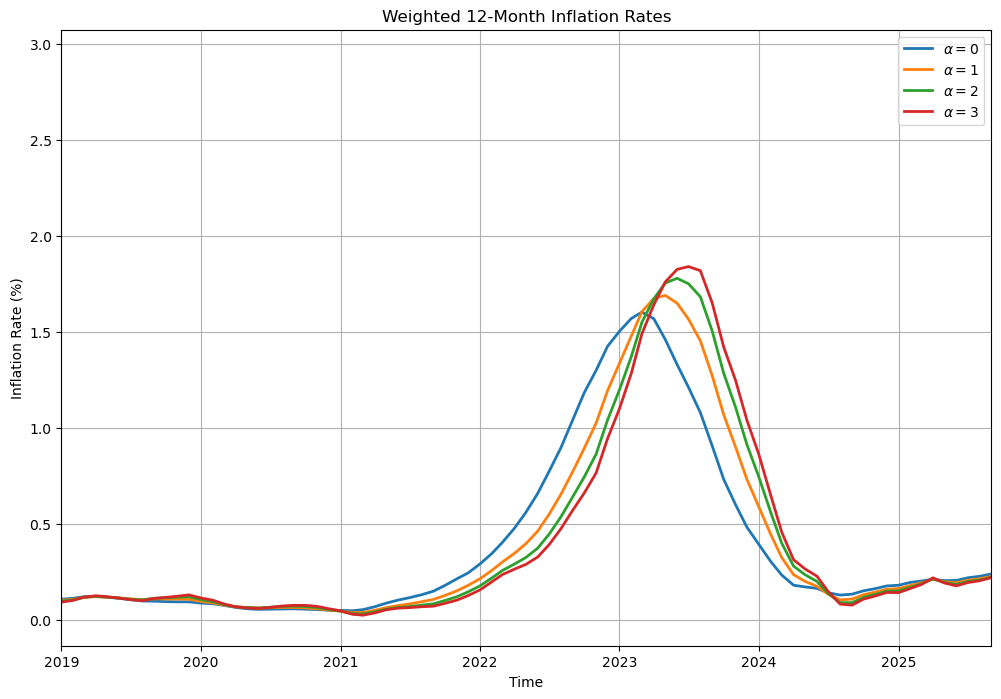

In [124]:
# plot the weighted 12-month inflation rates for alpha = 0,1,2,3 since 2019 add legend and labels
plt.figure(figsize=(12,8))
plt.plot(df['time'], df['pi12_alpha0'], label=r'$\alpha=0$', linewidth=2)   
plt.plot(df['time'], df['pi12_alpha1'], label=r'$\alpha=1$', linewidth=2)   
plt.plot(df['time'], df['pi12_alpha2'], label=r'$\alpha=2$', linewidth=2)   
plt.plot(df['time'], df['pi12_alpha3'], label=r'$\alpha=3$', linewidth=2)   
plt.xlim(pd.Timestamp('2019-01-01'), df['time'].max())
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.title('Weighted 12-Month Inflation Rates')
plt.legend()
plt.grid()
plt.show()

Weighted inflation measures show the surge as later and sharper when more weight is given to recent months (α=1–3), while the conventional 12-month rate (α=0) peaks earlier and more smoothly. Together, they illustrate how year-over-year inflation understates the intensity at the peak but signals an earlier turning point.

### 1.3 Core inflation

In [125]:
# load the variables () PRIS111 data since 2019 from DST
df_dst = DstApi('PRIS111').get_data()

C:\Users\tobia\AppData\Local\Temp\ipykernel_7952\2329786813.py:2: UserWarning: API call parameters are not specified. Parameters resulting in the download of the entire table will be automatically generated. This can result in massive data downloads.
  df_dst = DstApi('PRIS111').get_data()


In [126]:
# Clean the dataframe
I = df_dst['INDHOLD'] == '..'
df_dst.loc[I,'INDHOLD'] = 'nan'
df_dst['INDHOLD'] = df_dst['INDHOLD'].str.replace(',', '.')
df_dst['INDHOLD'] = df_dst['INDHOLD'].astype(float)
df_dst.head(5)


,VAREGR,ENHED,TID,INDHOLD
0,05.3.2.3 Strygejern,Ændring i forhold til samme måned året før (pct.),2006M07,NaN
1,"05.3.2.4 Toaster, brødrister o.l.",Indeks,2006M07,NaN
2,"05.3.2.4 Toaster, brødrister o.l.",Ændring i forhold til måneden før (pct.),2006M07,NaN
3,"05.3.2.4 Toaster, brødrister o.l.",Ændring i forhold til samme måned året før (pct.),2006M07,NaN
4,05.3.2.9 Andre mindre elektriske husholdningsa...,Indeks,2006M07,NaN


In [127]:
# All variables are in the same column 'INDHOLD', so we pivot the dataframe
df_pivot = df_dst.pivot_table(index='TID', columns=['VAREGR', 'ENHED'], values='INDHOLD')

# keep data since 2019
df_pivot = df_pivot[df_pivot.index >= '2019M01']

# format the time variable "TID" to datetime
df_pivot.index = pd.to_datetime(df_pivot.index, format='%YM%m')

# keep only the relevant columns
df_pivot = df_pivot.loc[:, [ ('00 Forbrugerprisindekset i alt', 'Indeks'), ('14.1 Forbrugerprisindeks ekskl. energi og ikke-forarbejdede fødevarer (Kerneinflation)', 'Indeks'), ('15.1 Forbrugerprisindeks ekskl. energi', 'Indeks')]]


In [128]:
# rename the columns
df_pivot.columns = [' | '.join(col) if isinstance(col, tuple) else col for col in df_pivot.columns]
df_pivot = df_pivot.rename(columns={
    '00 Forbrugerprisindekset i alt | Indeks': 'CPI total',
    '15.1 Forbrugerprisindeks ekskl. energi | Indeks': 'CPI excl. energy',
    '14.1 Forbrugerprisindeks ekskl. energi og ikke-forarbejdede fødevarer (Kerneinflation) | Indeks': 'Core CPI'
})
print(df_pivot.columns.tolist())


['CPI total', 'Core CPI', 'CPI excl. energy']


In [129]:
# calculate the 12 month inflation rate for each CPI measure
for col in df_pivot.columns:
    df_pivot[f'inflation_{col}'] = df_pivot[col].pct_change(periods=12) * 100

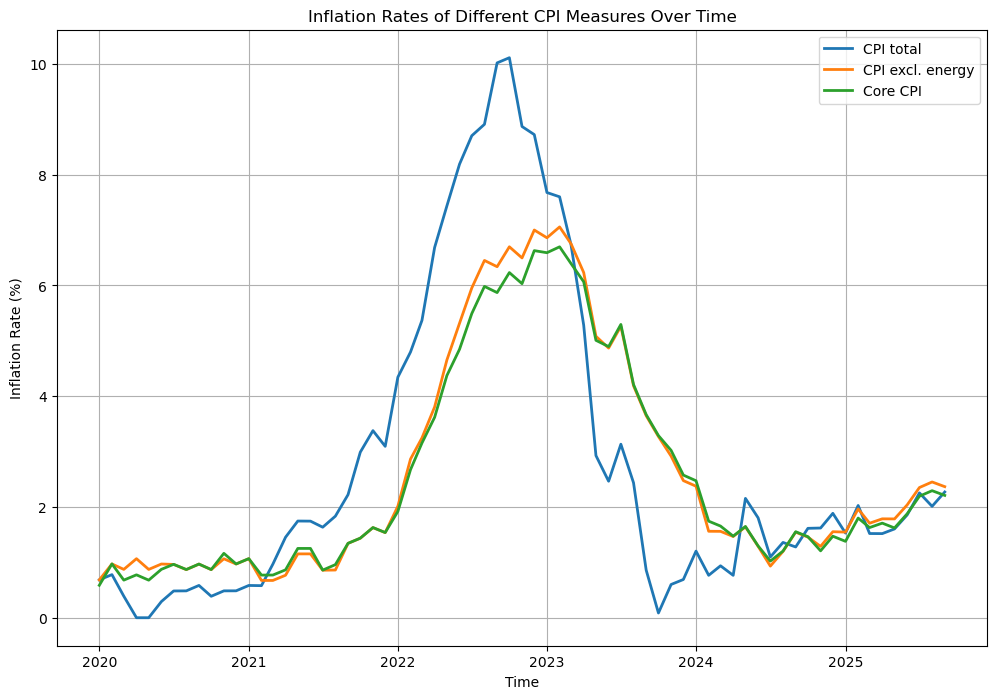

In [130]:
# plot the three different inflation rates over time
plt.figure(figsize=(12,8))
plt.plot(df_pivot.index, df_pivot['inflation_CPI total'], label='CPI total', linewidth=2)
plt.plot(df_pivot.index, df_pivot['inflation_CPI excl. energy'], label='CPI excl. energy', linewidth=2)
plt.plot(df_pivot.index, df_pivot['inflation_Core CPI'], label='Core CPI', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Inflation Rate (%)')
plt.title('Inflation Rates of Different CPI Measures Over Time')
plt.legend()
plt.grid()
plt.show()


**Forklar!!**

### 1.4 Disaggregated inflation in Denmark

## Question 2

We process the data by ...

In [131]:
data = dataproject.process_data(data)

NameError: name 'data' is not defined

In [ ]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

ax.plot(data['log_GDP'],label='log(GDP)')

ax.set_title('Log GDP over time')
ax.set_xlabel('Year')
ax.set_ylabel('Log GDP')

ax.legend();

We find that that ...